# Compute PCA

In [1]:
!pip install -q malariagen_data
!pip install -q scikit-allel
!pip install -q petl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.5/148.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.5/302.5 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.0 MB/s eta 0

### importing necessary package

In [2]:
import allel
import malariagen_data
import numpy as np
import pandas as pd
import dask
import dask.array as da
# silence some dask warnings
dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.diagnostics.progress import ProgressBar

In [ ]:
import random
#import functools
#import petl as ptl
#import itertools
import scipy
from pathlib import Path
from collections import Counter

In [ ]:
# plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib_venn as venn
import seaborn as sns

In [ ]:
#Mounting Google Drive
import os
from google.colab import drive
drive.mount("drive")

# make dir
results_dir = "drive/MyDrive/Genomic/"
os.makedirs(results_dir, exist_ok=True)

Mounted at drive


Importing malariagen data set    
Let's select the the sample set from

In [ ]:
ag3 = malariagen_data.Ag3("gs://vo_agam_release/", pre=True)
#ag3
sets = ["1191-VO-MULTI-OLOUGHLIN-VMF00106", "1191-VO-MULTI-OLOUGHLIN-VMF00140",
             "AG1000G-BF-A", "AG1000G-BF-B", "AG1000G-BF-C"]
df_samples = ag3.sample_metadata(sample_sets=sets)#.set_index("sample_id")
bf_samples = df_samples.query('country == "Burkina Faso"')
#bf_samples.groupby(['location', 'aim_species']).size()

#To access to the snp genotypes within the X chromosomes
chromX_gt = ag3.snp_calls(region="X", sample_sets=sets)


Load sample metadata:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# define population
bf_samples = df_samples.query('country == "Burkina Faso" and year > 2004')
s1, s2, pop_labels,pop_colors, = [], [], {}, {}
for iso, species in zip(bf_samples.location, bf_samples.aim_species):
    s1.append(iso[:4]+' (An. '+species+')')
bf_samples.insert(4, 'population', s1)
bf_samples_sel = pd.concat([bf_samples, bf_samples])
pop_ids = list(bf_samples.population.unique())

In [ ]:
#bf_samples.groupby(['location', 'year', 'aim_species']).size()

In [ ]:
# define population
bf_samples = df_samples.query('country == "Burkina Faso" and year > 2004')
s1, s2, pop_labels,pop_colors, = [], [], {}, {}
for iso, species in zip(bf_samples.location, bf_samples.aim_species):
    s1.append(iso[:4]+' (An. '+species+')')
bf_samples.insert(4, 'population', s1)
bf_samples_sel = pd.concat([bf_samples, bf_samples])
pop_ids = list(bf_samples.population.unique())

#pop_id
for idx, species in zip(bf_samples.location, bf_samples.aim_species):
  w = idx.split(' ')[0][:14]
  s2.append(w+' $An.'+species)
val = list(Counter(s2).keys())
for idx, vl in zip(pop_ids, val):
    pop_labels[idx]=vl
pop_labels

#pop_labels & pop_colors
colored = sns.color_palette("husl", len(pop_ids))
for i in range(len(pop_ids)):
    pop_colors[pop_ids[i]] = colored[i]

pop_color = {'Bana (An. coluzzii)':'#7FFFD4', 'Pala (An. coluzzii)':'#008000', 'Sour (An. coluzzii)':'#9ACD32',
             'Bana (An. gambiae)':'#FF00FF', 'Pala (An. gambiae)':'#C20078', 'Sour (An. gambiae)':'#9A0EEA',
             'Bana (An. arabiensis)':'#FFA500', 'Pala (An. arabiensis)':'#DAA520', 'Sour (An. arabiensis)':'#FF6347',
             'Bana (An. intermediate_gambiae_coluzzii)':'#580F41', 'Pala (An. intermediate_gambiae_coluzzii)':'#01153E'
             }
#pop_cohort
coh_pop = dict([(f"{p}", list(df.index)) for (p), df in bf_samples.reset_index().groupby(['population'])])
ls1 = ['Pala (An. gambiae)', 'Sour (An. gambiae)', 'Sour (An. coluzzii)', 'Bana (An. gambiae)',
       'Pala (An. arabiensis)', 'Bana (An. coluzzii)', 'Pala (An. coluzzii)']
pop_idx = []
for pop in ls1:
  pop_idx = pop_idx + coh_pop[pop]
len(pop_idx)

#remove some populations
pop_rm = ['Bana (An. arabiensis)', 'Bana (An. intermediate_gambiae_coluzzii)',
          'Pala (An. intermediate_gambiae_coluzzii)', 'Sour (An. arabiensis)']
#del s1, s2, val, colored

In [ ]:
### Load PCA data
def load_coords(file='coords.npy'):
  return np.load(f'drive/MyDrive/Genomic/PCA/{file}')

def load_model(file='model.npy'):
  return np.load(f'drive/MyDrive/Genomic/PCA/{file}', allow_pickle='TRUE').item()

In [ ]:
def plot_variance(model):
  fig = plt.figure(figsize=(20, 6))
  ax = fig.add_subplot(121)
  if 'variance' in globals():
      ax.plot(variance, 'go')
  else:
      ax.plot(model.explained_variance_ratio_, 'go')
  ax.set_xlabel("principal component")
  ax.set_ylabel("variance explained")
  plt.xticks(np.arange(0,20, 1));

In [ ]:
ed = 'Pala (An. arabiensis)'
ed.split(' (')

['Pala', 'An. arabiensis)']

In [ ]:
def marker_style (pop_ids):
  marker = {}
  for pop in pop_ids:
    if pop.split(' (')[1]=='An. gambiae)':
      marker[pop] = 'o'
    elif pop.split(' (')[1]=='An. coluzzii)':
      marker[pop] = 'D'
    elif pop.split(' (')[1]=='An. arabiensis)':
      marker[pop] = 'v'
    elif pop.split(' (')[1]=='An. intermediate_gambiae_coluzzii)':
      marker[pop] = '*'
    else:
      marker[pop] = 'h'
  return marker


In [ ]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in ls1:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker=marker_style(pop_ids)[pop], linestyle=' ', color=pop_color[pop],
                label=pop, markersize=6, mec='black', mew=0.2)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model[pc2]*100))

In [ ]:
def fig_pca(coords, model, title, sample_population, fig_name=None):
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(18, 9))
    ax = fig.add_subplot(231)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)

    ax = fig.add_subplot(232)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)

    ax = fig.add_subplot(233)
    plot_pca_coords(coords, model, 4, 5, ax, sample_population)

    ax = fig.add_subplot(234)
    plot_pca_coords(coords, model, 6, 7, ax, sample_population)

    ax = fig.add_subplot(235)
    plot_pca_coords(coords, model, 8, 9, ax, sample_population)

    ax = fig.add_subplot(236)
    plot_pca_coords(coords, model, 10, 11, ax, sample_population)

    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

    fig.suptitle(title, y=1.02)
    fig.tight_layout()

    if fig_name:
      fig.savefig(f"drive/MyDrive/Genomic/PCA/{fig_name}.png", dpi=300, bbox_inches='tight')


In [ ]:
def fig_pca1_2(coords, model, title, sample_population, fig_name=None):
    # plot coords for PCs 1 vs 2
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot()
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)

    ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')


    fig.suptitle(title, y=1.02)
    fig.tight_layout()

    if fig_name:
      fig.savefig(f"drive/MyDrive/Genomic/PCA/{fig_name}.png", dpi=300, bbox_inches='tight')


## PCA in the X chrom

In [ ]:
coords_X = load_coords(file='X_coords.npy')
model_X = load_model(file='X_model.npy')

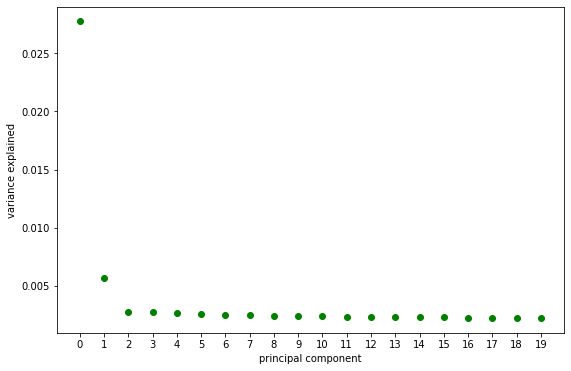

In [ ]:
plot_variance(model_X)

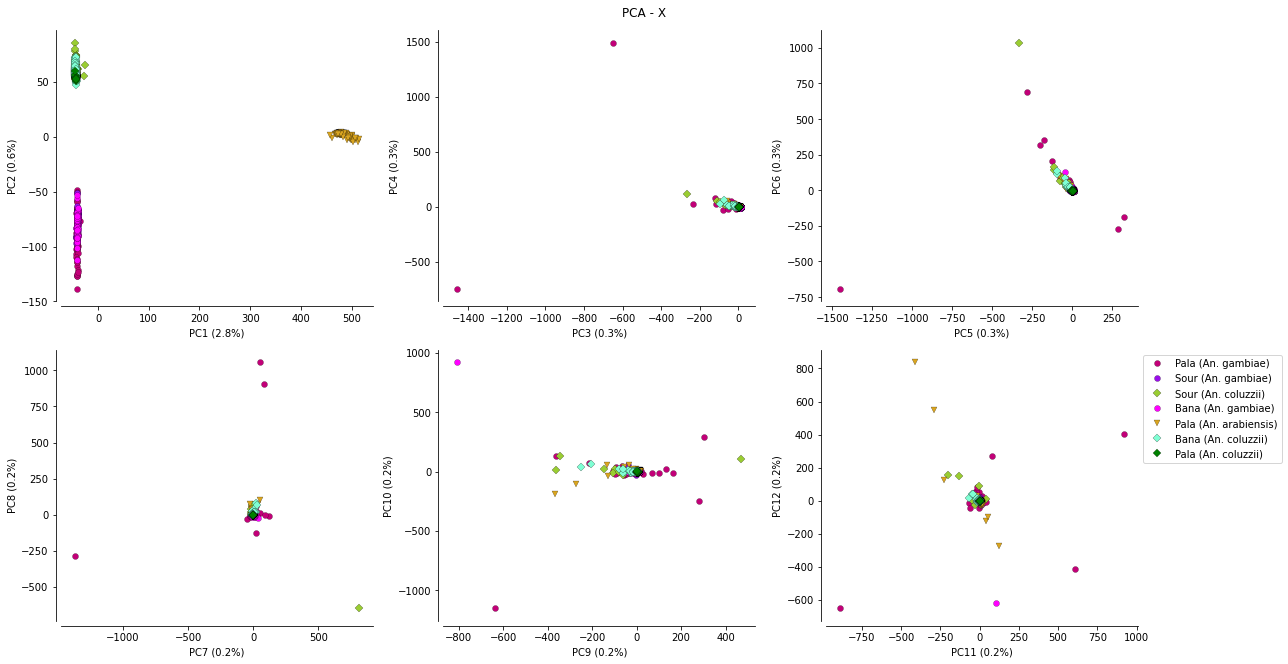

In [ ]:
fig_pca(coords_X, model_X.explained_variance_ratio_ ,'PCA - X', bf_samples.population.values, fig_name='X_PCA')

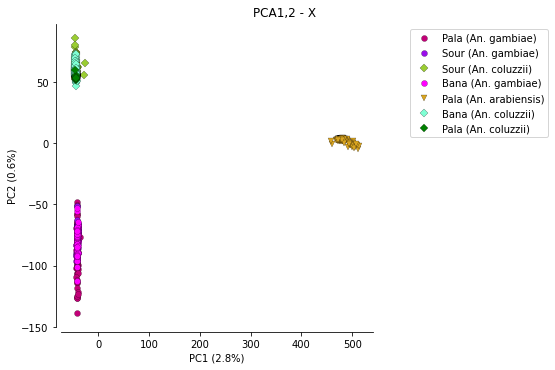

In [ ]:
fig_pca1_2(coords_X, model_X.explained_variance_ratio_ ,'PCA1,2 - X', bf_samples.population.values, fig_name='X_PCA12')

## PCA in the 2L chrom

In [ ]:
coords_2L = load_coords(file='2L_coords.npy')
model_2L = load_model(file='2L_model.npy')

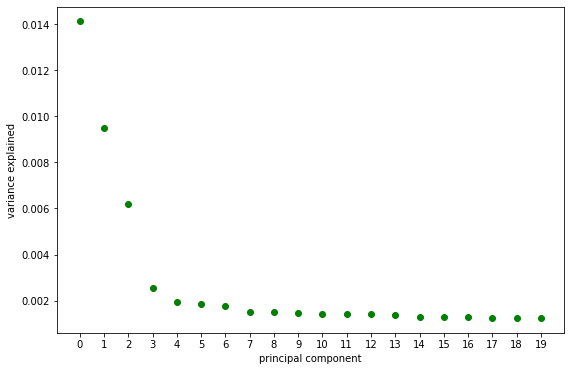

In [ ]:
plot_variance(model_2L)

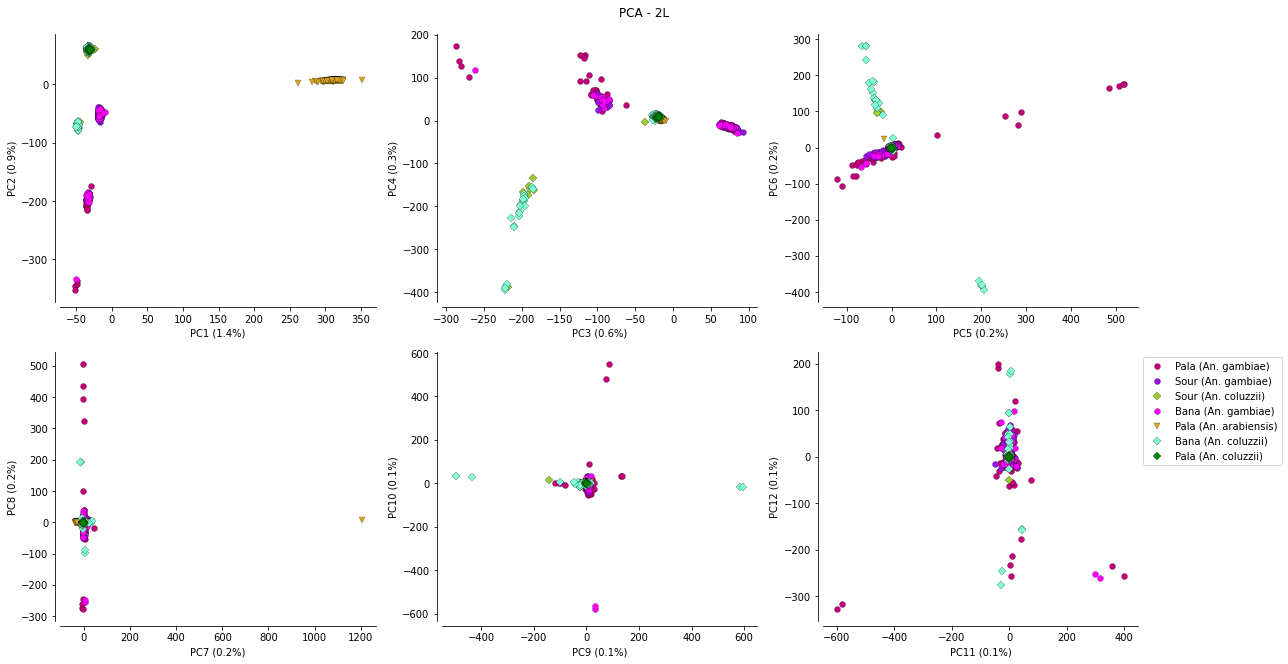

In [ ]:
fig_pca(coords_2L, model_2L.explained_variance_ratio_ ,'PCA - 2L', bf_samples.population.values, fig_name='2L_PCA')

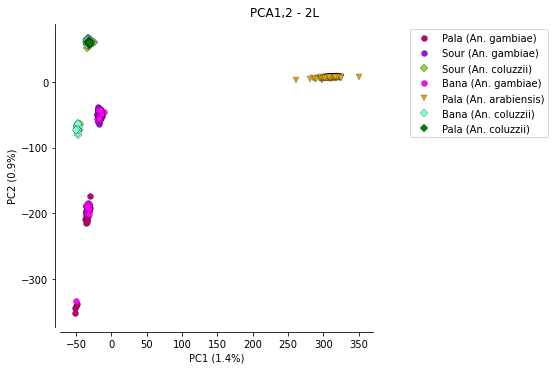

In [ ]:
fig_pca1_2(coords_2L, model_2L.explained_variance_ratio_ ,'PCA1,2 - 2L', bf_samples.population.values, fig_name='2L_PCA12')

## PCA in the 2R chrom

In [ ]:
coords_2R = load_coords(file='2R_coords.npy')
model_2R = load_model(file='2R_model.npy')

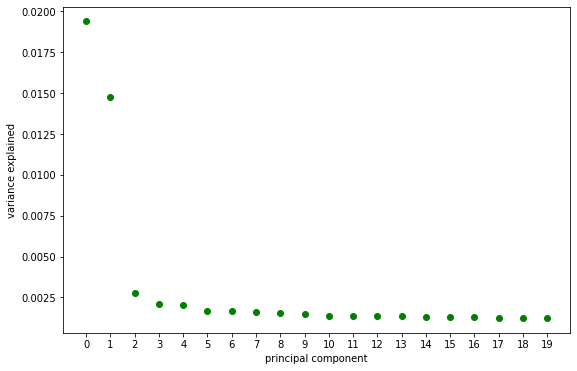

In [ ]:
plot_variance(model_2R)

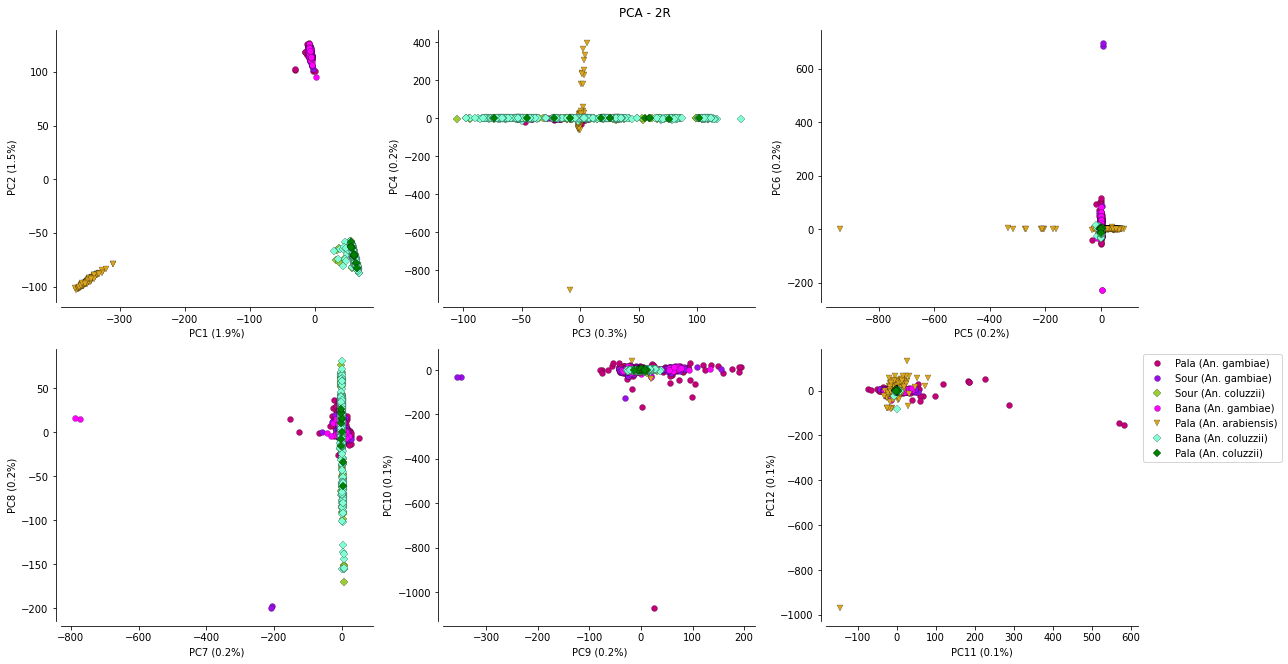

In [ ]:
fig_pca(coords_2R, model_2R.explained_variance_ratio_ ,'PCA - 2R', bf_samples.population.values, fig_name='2R_PCA')

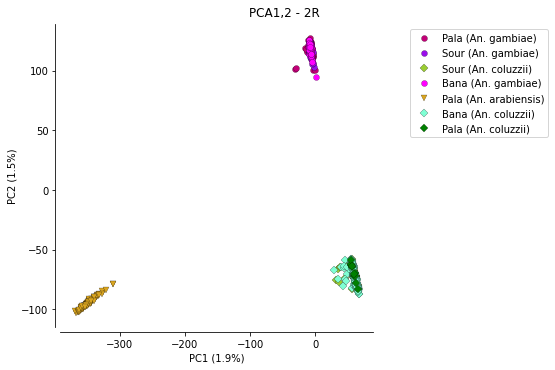

In [ ]:
fig_pca1_2(coords_2R, model_2R.explained_variance_ratio_ ,'PCA1,2 - 2R', bf_samples.population.values, fig_name='2R_PCA12')

## PCA in the 3L chrom

In [ ]:
coords_3L = load_coords(file='3L_coords.npy')
model_3L = load_model(file='3L_model.npy')

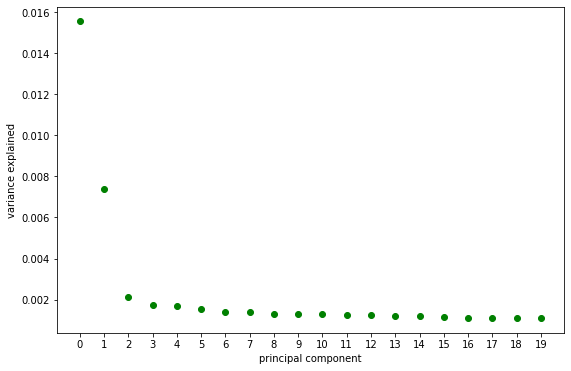

In [ ]:
plot_variance(model_3L)

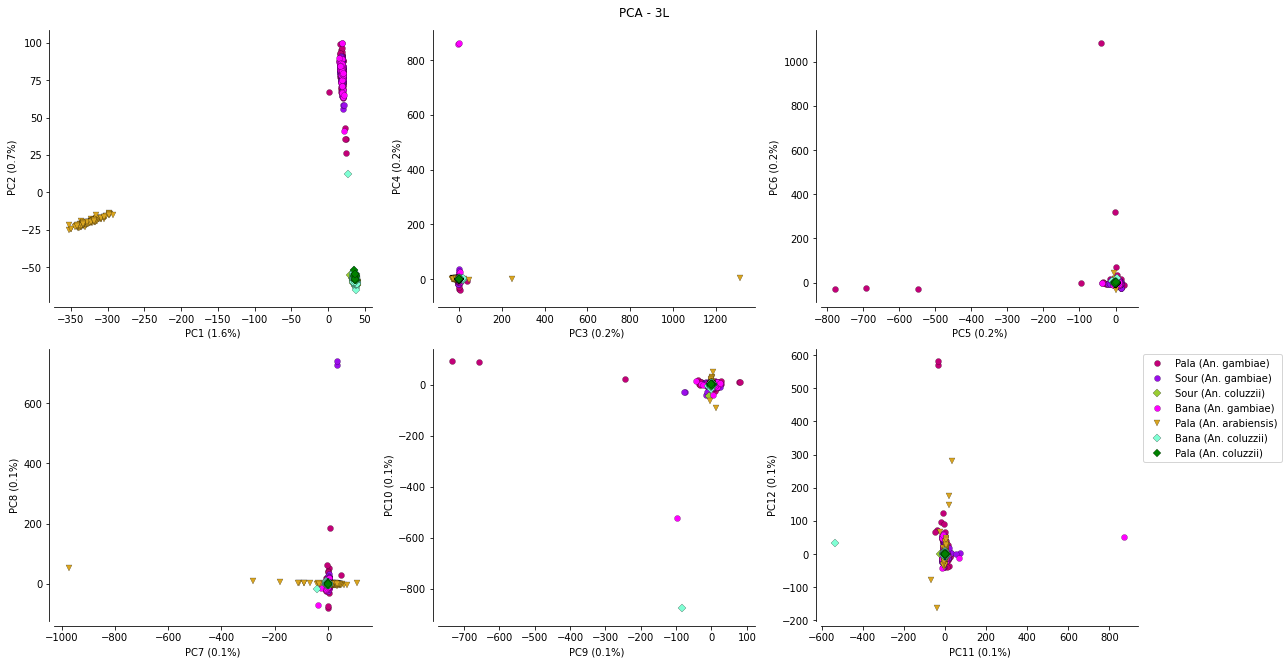

In [ ]:
fig_pca(coords_3L, model_3L.explained_variance_ratio_ ,'PCA - 3L', bf_samples.population.values, fig_name='3L_PCA')

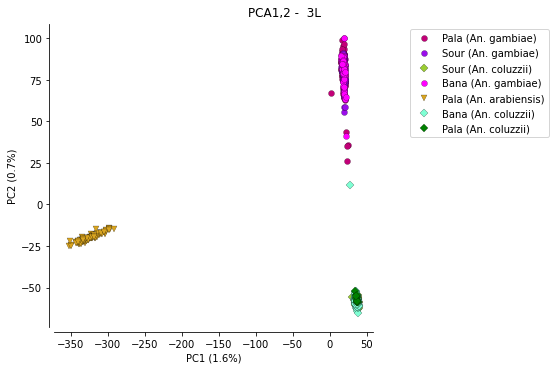

In [ ]:
fig_pca1_2(coords_3L, model_3L.explained_variance_ratio_ ,'PCA1,2 -  3L', bf_samples.population.values, fig_name='3L_PCA12')

## PCA in the 3R chrom

In [ ]:
coords_3R = load_coords(file='3R_coords.npy')
model_3R = load_model(file='3R_model.npy')

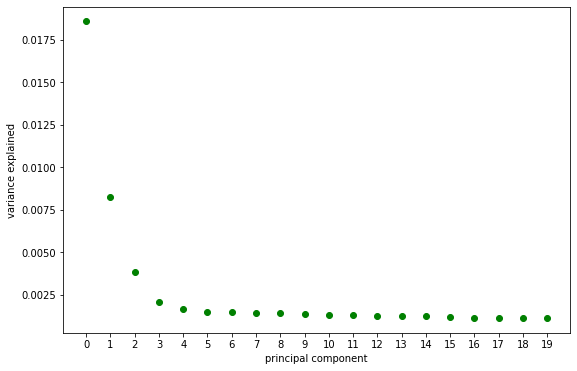

In [ ]:
plot_variance(model_3R)

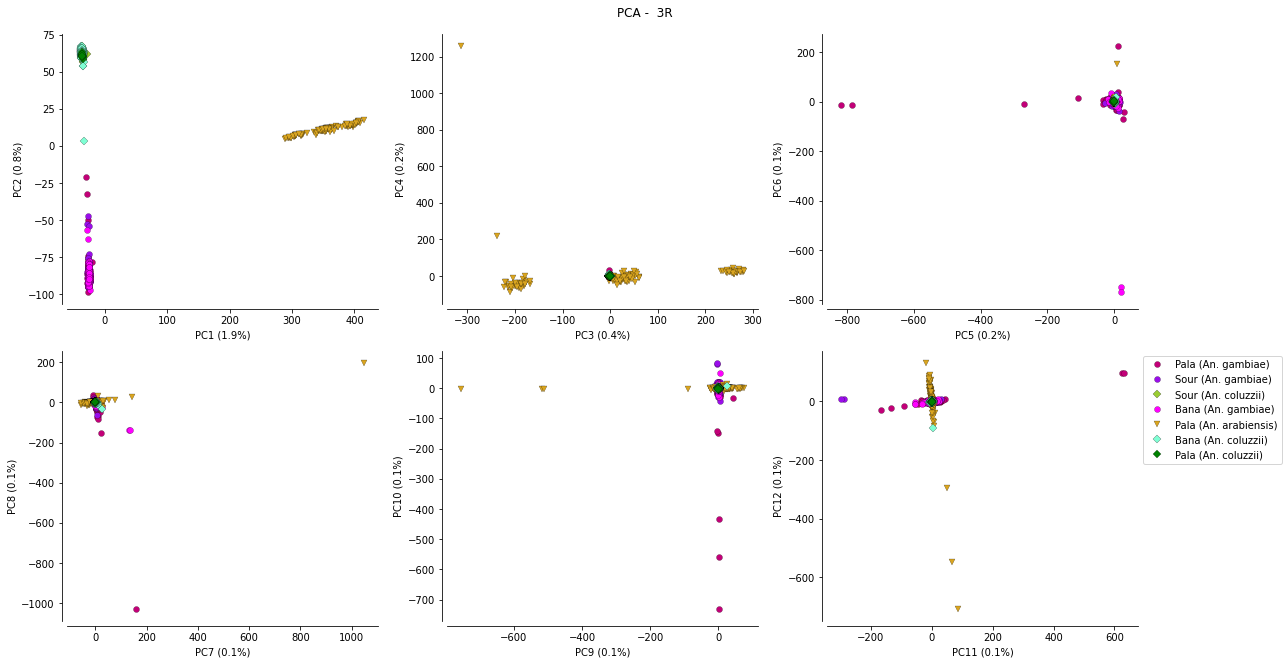

In [ ]:
fig_pca(coords_3R, model_3R.explained_variance_ratio_ ,'PCA -  3R', bf_samples.population.values,fig_name='3R_PCA')

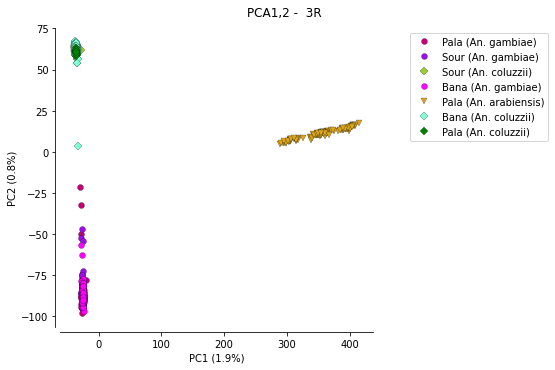

In [ ]:
fig_pca1_2(coords_3R, model_3R.explained_variance_ratio_ ,'PCA1,2 -  3R', bf_samples.population.values, fig_name='3R_PCA12')

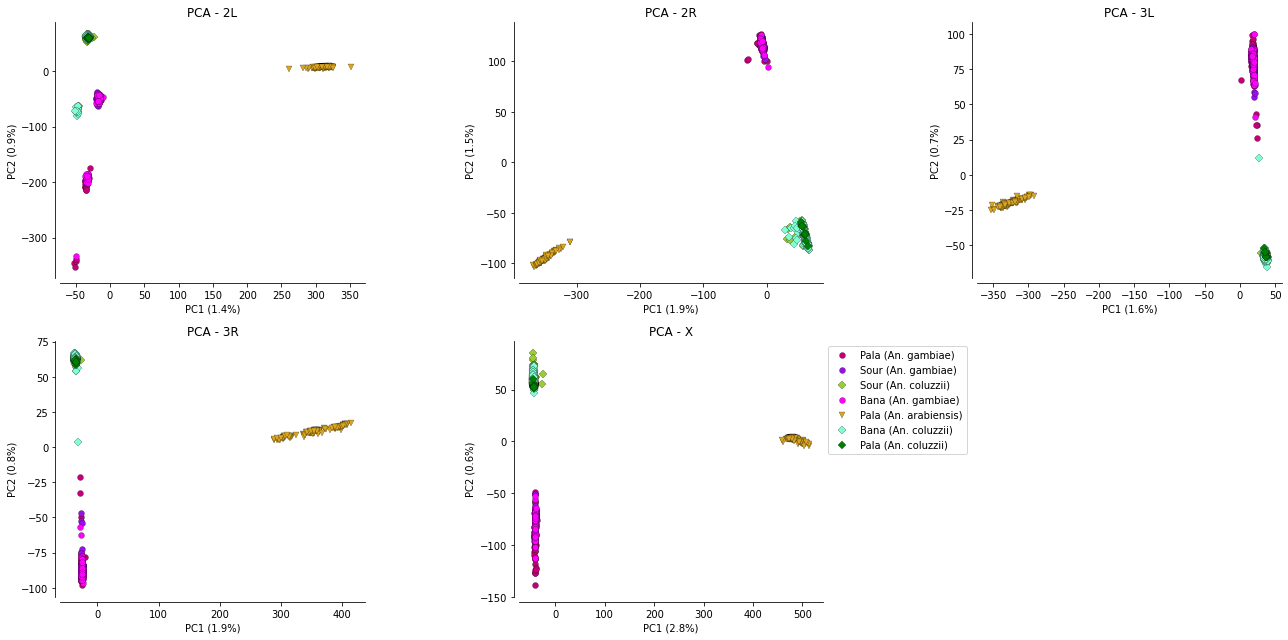

In [ ]:
fig = plt.figure(figsize=(18, 9))

ax = fig.add_subplot(231)
plot_pca_coords(coords_2L, model_2L.explained_variance_ratio_, 0, 1, ax, bf_samples.population.values)
plt.title('PCA - 2L')

ax = fig.add_subplot(232)
plot_pca_coords(coords_2R, model_2R.explained_variance_ratio_, 0, 1, ax, bf_samples.population.values)
plt.title('PCA - 2R')

ax = fig.add_subplot(233)
plot_pca_coords(coords_3L, model_3L.explained_variance_ratio_, 0, 1, ax, bf_samples.population.values)
plt.title('PCA - 3L')

ax = fig.add_subplot(234)
plot_pca_coords(coords_3R, model_3R.explained_variance_ratio_, 0, 1, ax, bf_samples.population.values)
plt.title('PCA - 3R')

ax = fig.add_subplot(235)
plot_pca_coords(coords_X, model_X.explained_variance_ratio_, 0, 1, ax, bf_samples.population.values)
plt.title('PCA - X')

ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

fig.tight_layout()
fig.savefig(f"drive/MyDrive/Genomic/PCA/ALL_PCA12.png", dpi=300, bbox_inches='tight')